In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from pathlib import Path
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
data_dir = Path("/kaggle/input/brainmetshare-t1-gd/BrainMetShare_t1_gd")

### U-NET Model

- Consider adding batchnorm to doubleConv

In [56]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x


- consider adding other encoder layer

In [57]:
class UNETModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Down
        self.down1 = DoubleConv(in_channels,64)
        self.down2 = DoubleConv(64,128)
        self.down3 = DoubleConv(128,256)
        self.bottleneck = DoubleConv(256,512)

        self.pool = nn.MaxPool2d(2)

        # Up
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.right1 = DoubleConv(512, 256) # 256 (up) + 256 (encoder3)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.right2 = DoubleConv(256, 128) # 128 (up) + 128 (encoder2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.right3 = DoubleConv(128, 64) # 64 (up) + 64 (encoder1)

        # Out
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Down
        encoder1 = self.down1(x)
        encoder2 = self.down2(self.pool(encoder1))
        encoder3 = self.down3(self.pool(encoder2))

        # Bottleneck
        bneck = self.bottleneck(self.pool(encoder3))

        # Up
        decoder1 = self.up1(bneck)
        decoder1 = self.right1(torch.cat([decoder1, encoder3], dim=1))
        decoder2 = self.up2(decoder1)
        decoder2 = self.right2(torch.cat([decoder2, encoder2], dim=1))
        decoder3 = self.up3(decoder2)
        decoder3 = self.right3(torch.cat([decoder3, encoder1], dim=1))

        # Out
        out = self.out(decoder3)
        return out


In [9]:
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        return x

In [10]:
class UNET3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.pool = nn.MaxPool3d(2)
        # Down
        self.down1 = DoubleConv3D(in_channels,32)
        self.down2 = DoubleConv3D(32,64)
        self.down3 = DoubleConv3D(64,128)

        #  Bottleneck
        self.bottleneck = DoubleConv3D(128,256)

        # Up
        self.up1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.right1 = DoubleConv3D(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.right2 = DoubleConv3D(128, 64)
        self.up3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.right3 = DoubleConv3D(64, 32)

        # Out
        self.out = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Down
        encoder1 = self.down1(x)
        encoder2 = self.down2(self.pool(encoder1))
        encoder3 = self.down3(self.pool(encoder2))

        # Bottleneck
        bneck = self.bottleneck(self.pool(encoder3))

        # Up
        decoder1 = self.up1(bneck)
        decoder1 = self.right1(torch.cat([decoder1, encoder3], dim=1))
        decoder2 = self.up2(decoder1)
        decoder2 = self.right2(torch.cat([decoder2, encoder2], dim=1))
        decoder3 = self.up3(decoder2)
        decoder3 = self.right3(torch.cat([decoder3, encoder1], dim=1))

        # Out
        out = self.out(decoder3)
        return out


### Preparing Data

In [60]:
def largest_slice(mask):
    slice_sums = mask.sum(axis=(0, 1))
    z = int(np.argmax(slice_sums))
    return z

In [61]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class MRIDataset(Dataset):
    def __init__(self, dir_list):
        self.sample_dirs = dir_list  # Already a list of Path objects

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        image = np.load(sample_dir / "image.npy")
        mask = np.load(sample_dir / "mask.npy")

        # Conver to tensor
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        # Take slice
        z = largest_slice(mask)
        image = image[:,:,z].unsqueeze(0)
        #image = torch.stack([image[z,:,:],image[:,z,:],image[:,:,z]], dim=0)
        mask = mask[:,:,z].unsqueeze(0)

        

        return image, mask, sample_dir.name

In [5]:
from torch.utils.data import Dataset

class MRIDataset3D(Dataset):
    def __init__(self, dir_list, patch_size=(96, 96, 96), stride=(96, 96, 96)):
        self.patch_size = patch_size
        self.stride = stride
        self.sample_dirs = dir_list
        self.patch_indices = []  # list of (sample_idx, z, y, x)

        # Precompute all patch indices
        for sample_idx, sample_dir in enumerate(self.sample_dirs):
            image = np.load(sample_dir / "image.npy")  # assume shape (D, H, W)
            D, H, W = image.shape
            pd, ph, pw = patch_size
            sd, sh, sw = stride

            for z in range(0, max(1, D - pd + 1), sd):
                for y in range(0, max(1, H - ph + 1), sh):
                    for x in range(0, max(1, W - pw + 1), sw):
                        self.patch_indices.append((sample_idx, z, y, x))

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        sample_idx, z, y, x = self.patch_indices[idx]
        sample_dir = self.sample_dirs[sample_idx]

        image = np.load(sample_dir / "image.npy")
        mask = np.load(sample_dir / "mask.npy")

        patch_img = image[z:z+self.patch_size[0], y:y+self.patch_size[1], x:x+self.patch_size[2]]
        patch_mask = mask[z:z+self.patch_size[0], y:y+self.patch_size[1], x:x+self.patch_size[2]]

        # Add channel dim and convert to torch
        patch_img = torch.tensor(patch_img, dtype=torch.float32).unsqueeze(0)
        patch_mask = torch.tensor(patch_mask, dtype=torch.float32).unsqueeze(0)

        return patch_img, patch_mask, sample_dir.name

In [6]:
from sklearn.model_selection import train_test_split

# Split data into train and test
dirs = sorted([p for p in data_dir.iterdir() if p.is_dir()])
train_dirs, test_dirs = train_test_split(dirs, test_size=0.2, random_state=12)
train_data = MRIDataset3D(train_dirs)
test_data = MRIDataset3D(test_dirs)

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

In [65]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()



In [66]:
def combined_loss(logits, targets):
    return DiceLoss()(logits, targets) + nn.BCEWithLogitsLoss()(logits, targets)

In [67]:
def safe_dice_loss(logits, targets, smooth=1e-6):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    valid = targets.sum(dim=(2, 3)) > 0  # skip blank targets
    intersection = (probs * targets).sum(dim=(2, 3))
    union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice[valid].mean() if valid.any() else torch.tensor(0.0, device=logits.device)

In [ ]:
model = UNET3D().to(device)
criterion = combined_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 30
train_losses = [0] * epochs
test_losses = [0] * epochs
for i in range(epochs):
    model.train()
    train_loss_total = 0
    for b, (img_train, mask_train, names) in enumerate(train_loader):
        img_train = img_train.to(device)
        mask_train = mask_train.to(device)

        mask_pred = model(img_train)
        loss = criterion(mask_pred, mask_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()

    train_losses[i] = train_loss_total / len(train_loader)
    print(f'Epoch: {i+1} Loss: {train_loss_total / len(train_loader)}')

    # testing
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for b, (img_test, mask_test, names) in enumerate(test_loader):
            img_test = img_test.to(device)
            mask_test = mask_test.to(device)

            mask_pred = model(img_test)
            loss = criterion(mask_pred, mask_test)
            test_loss_total += loss.item()

    test_losses[i] = test_loss_total / len(test_loader)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
# Save model weights
torch.save(model.state_dict(), "/kaggle/working/unet3d_model.pth")

In [11]:
model = UNET3D().to(device)
model.load_state_dict(torch.load("/kaggle/working/unet3d_model.pth"))
model.eval()

UNET3D(
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): DoubleConv3D(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): DoubleConv3D(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down3): DoubleConv3D(
    (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm

In [14]:
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(2, 3, 4))
    union = ((preds + targets) > 0).float().sum(dim=(2, 3, 4))

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [15]:
def dice_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(2, 3, 4))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3, 4))

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()


In [16]:
model.eval()
with torch.no_grad():
    iou_total = 0
    dice_total = 0
    for img_batch, mask_batch, _ in test_loader:
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)

        preds = model(img_batch)

        iou_total += iou_score(preds, mask_batch)
        dice_total += dice_score(preds, mask_batch)

    print("Mean IoU:", iou_total / len(test_loader))
    print("Mean Dice Score:", dice_total / len(test_loader))

Mean IoU: 0.4993961264521921
Mean Dice Score: 0.848360726328625


In [20]:
def sliding_window_inference(volume, model, patch_size=(96, 96, 96), stride=(48, 48, 48)):
    model.eval()
    device = next(model.parameters()).device
    
    D, H, W = volume.shape
    output = np.zeros((1, D, H, W), dtype=np.float32)
    count_map = np.zeros((1, D, H, W), dtype=np.float32)

    with torch.no_grad():
        for z in range(0, D - patch_size[0] + 1, stride[0]):
            for y in range(0, H - patch_size[1] + 1, stride[1]):
                for x in range(0, W - patch_size[2] + 1, stride[2]):
                    patch = volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]
                    patch = (patch - patch.mean()) / (patch.std() + 1e-8)

                    input_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                    pred = torch.sigmoid(model(input_tensor)).cpu().numpy()[0]

                    output[:, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += pred
                    count_map[:, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += 1

    count_map[count_map == 0] = 1
    averaged_output = output / count_map
    return averaged_output.squeeze()  # shape: (D, H, W)

def largest_slice(mask):
    """Find the axial slice with the largest tumor region"""
    z_scores = [np.sum(mask[:, :, z]) for z in range(mask.shape[2])]
    return int(np.argmax(z_scores))

def run_full_inference_visualization(sample_dirs, model, threshold=0.15, patch_size=(96, 96, 96), stride=(48, 48, 48)):
    model.eval()

    for sample_dir in sample_dirs:
        image = np.load(sample_dir / "image.npy")  # (D, H, W)
        mask = np.load(sample_dir / "mask.npy")    # (D, H, W)

        # Predict
        pred = sliding_window_inference(image, model, patch_size=patch_size, stride=stride)
        pred_bin = (pred > threshold).astype(np.uint8)

        # Plot the slice with largest tumor
        z = largest_slice(mask)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image[:, :, z], cmap="gray")
        plt.title(f"{sample_dir.name} (MRI)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask[:, :, z], cmap="Reds")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_bin[:, :, z], cmap="Blues")
        plt.title("Prediction")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


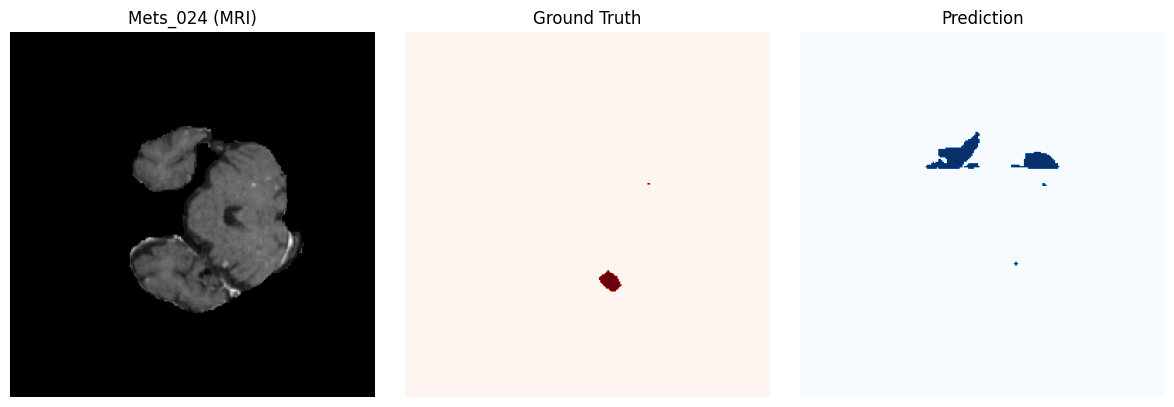

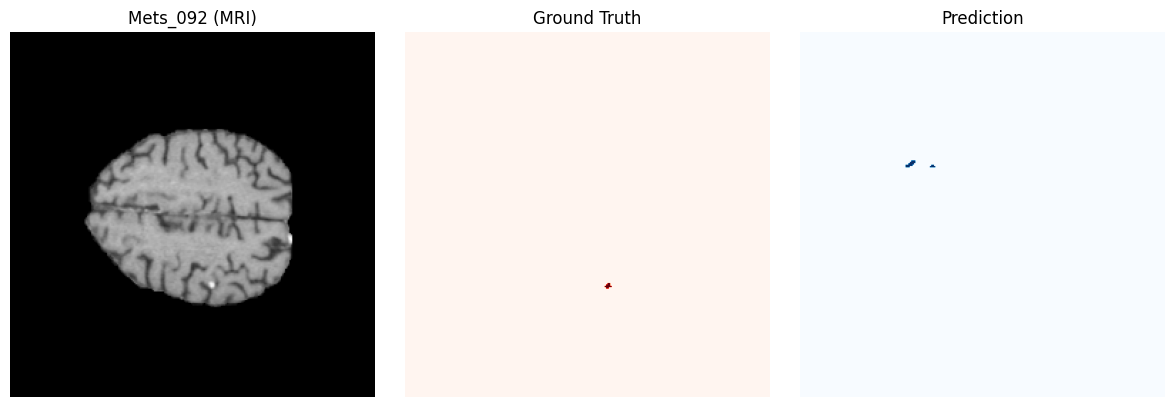

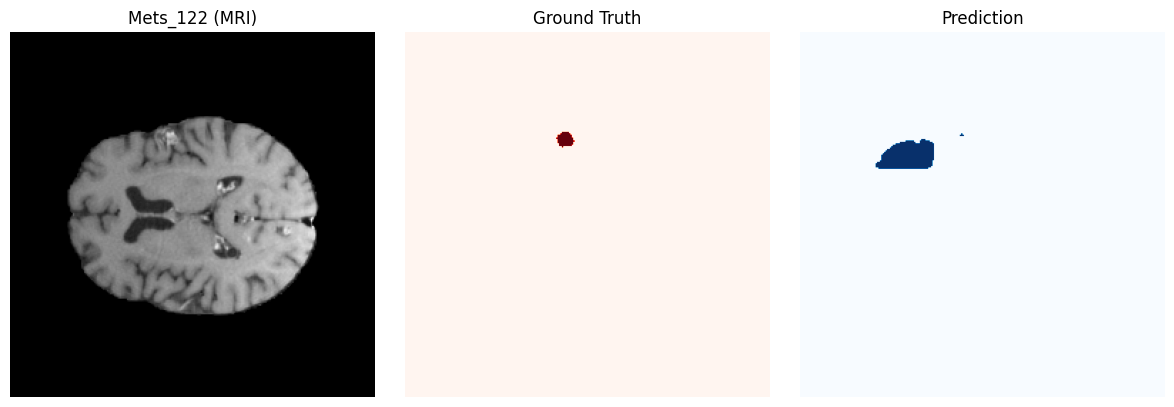

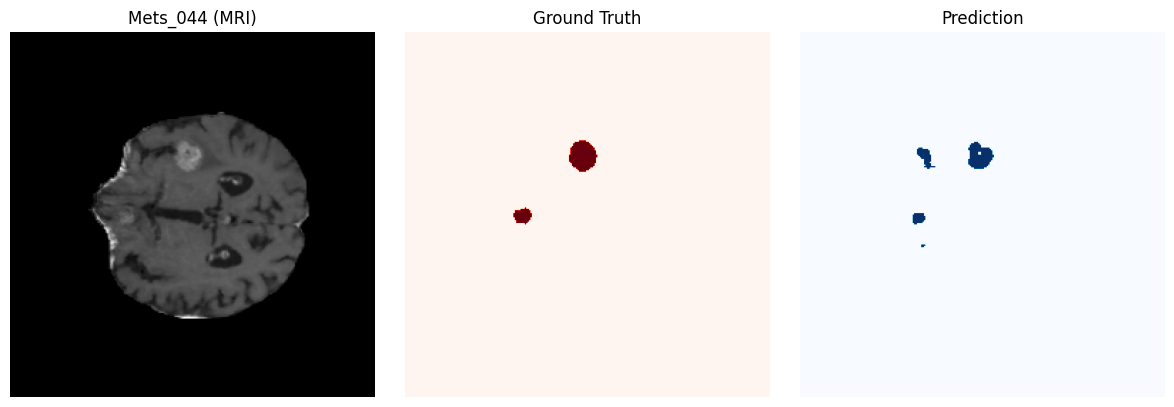

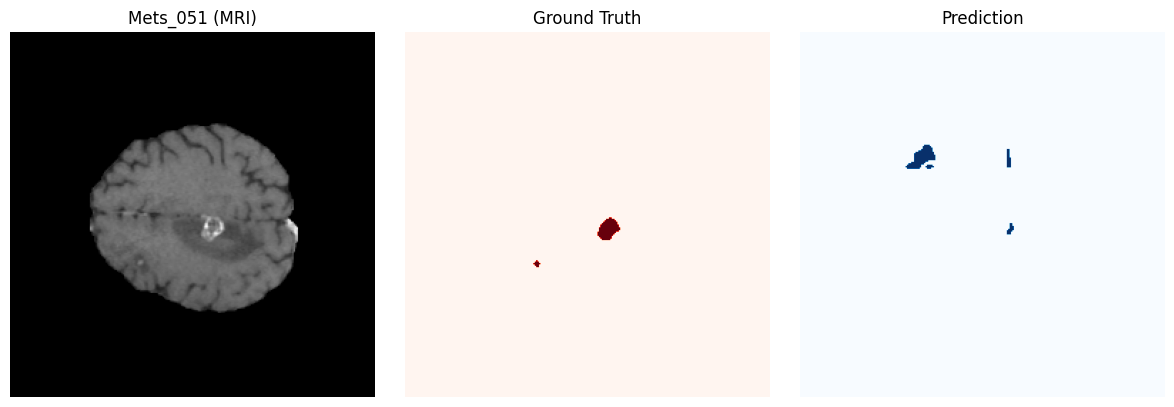

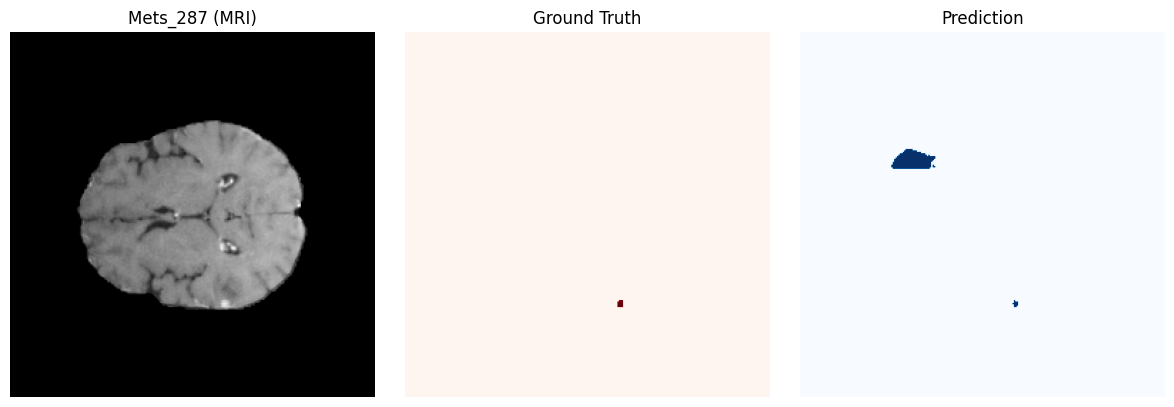

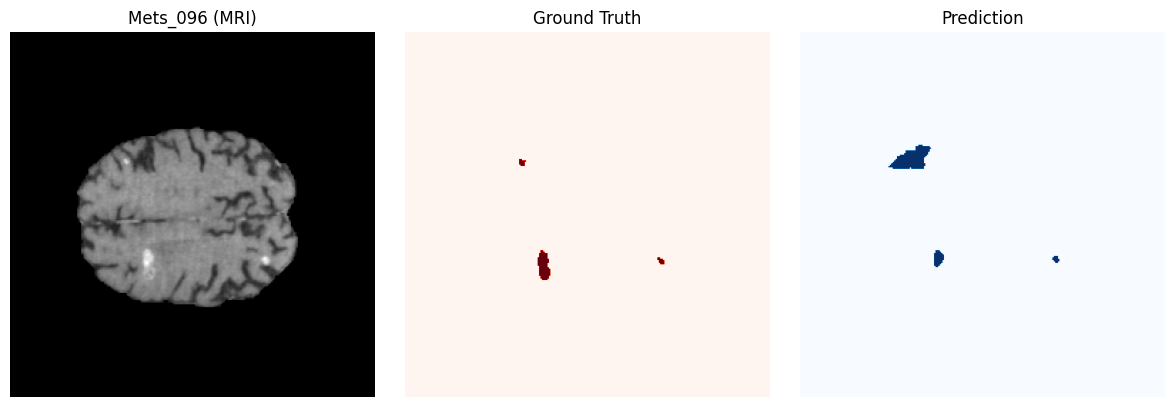

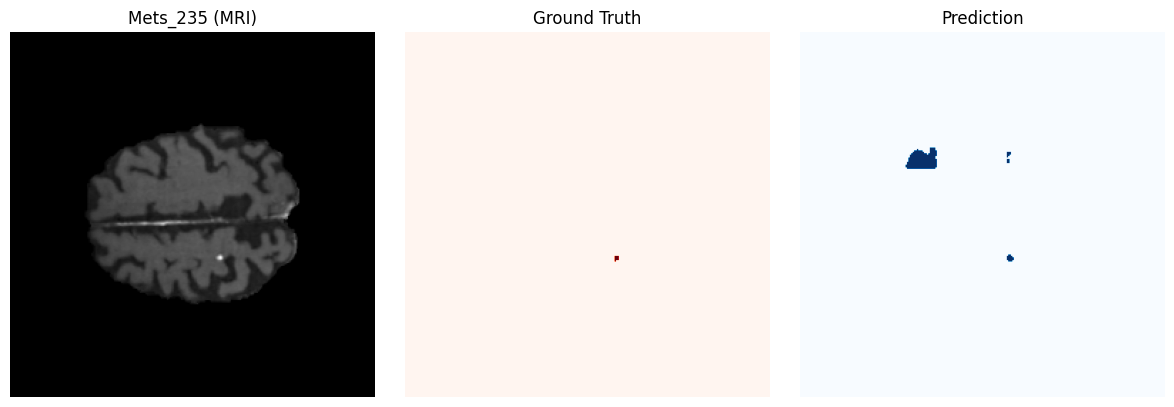

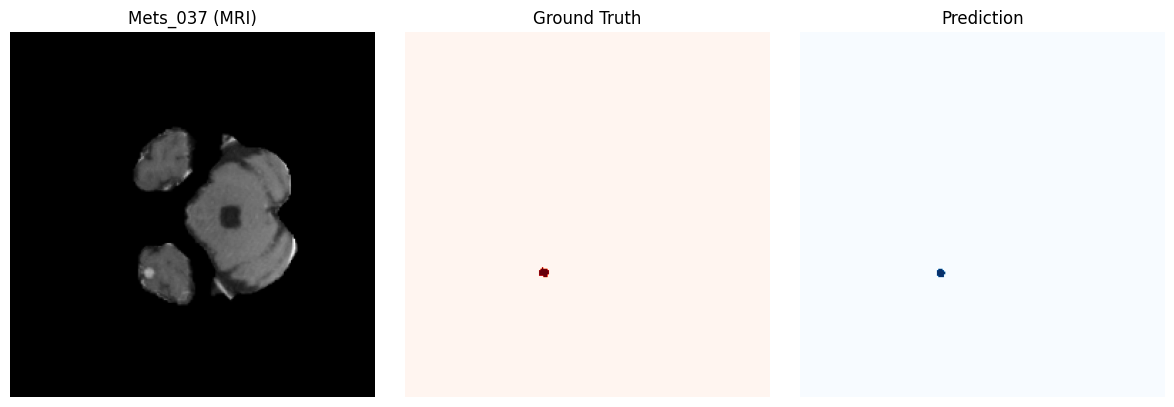

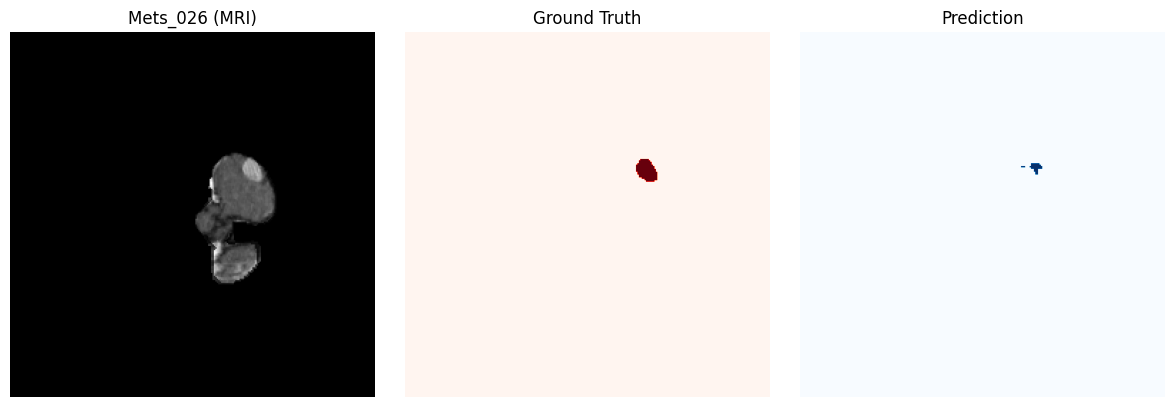

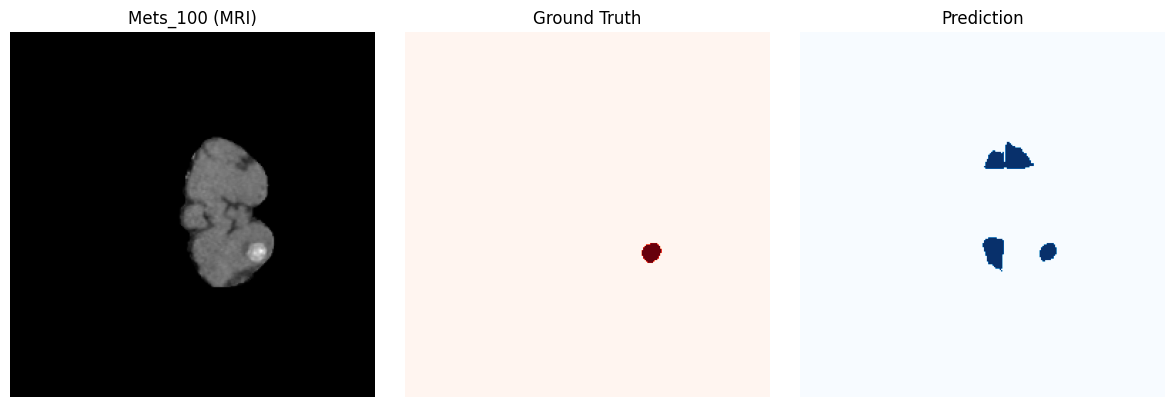

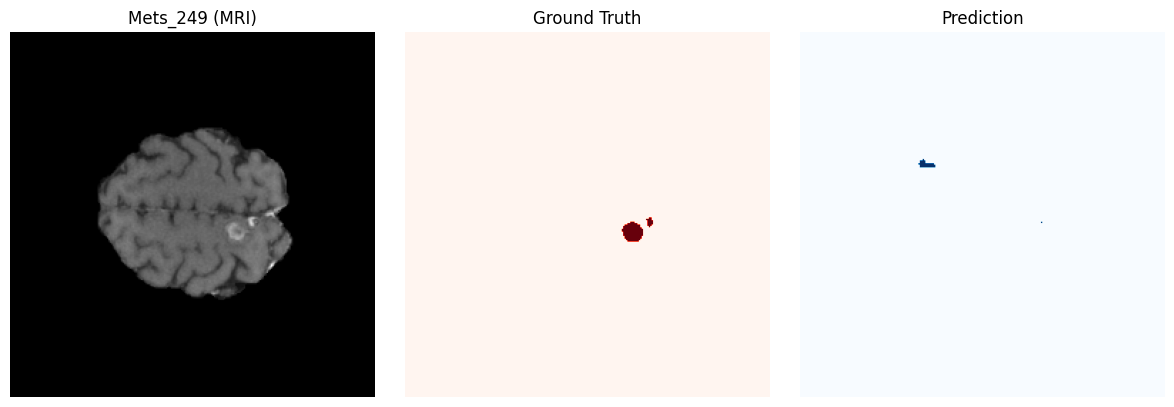

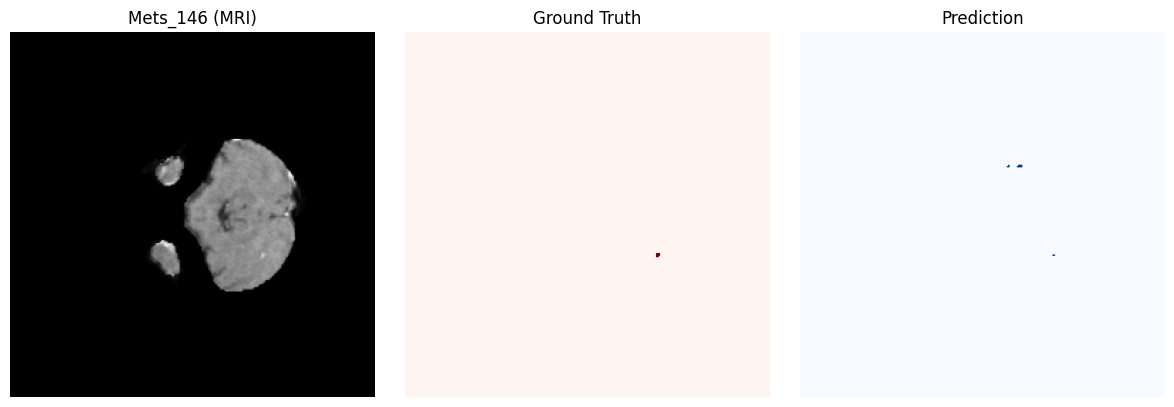

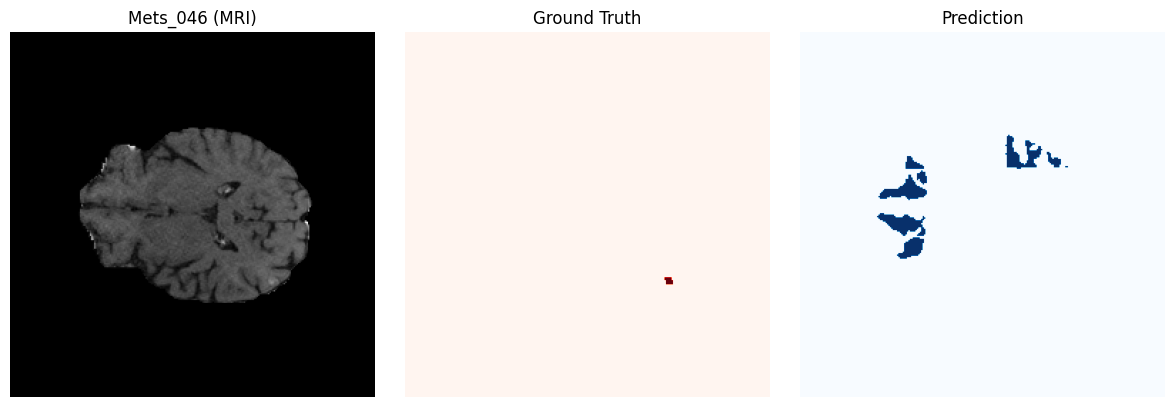

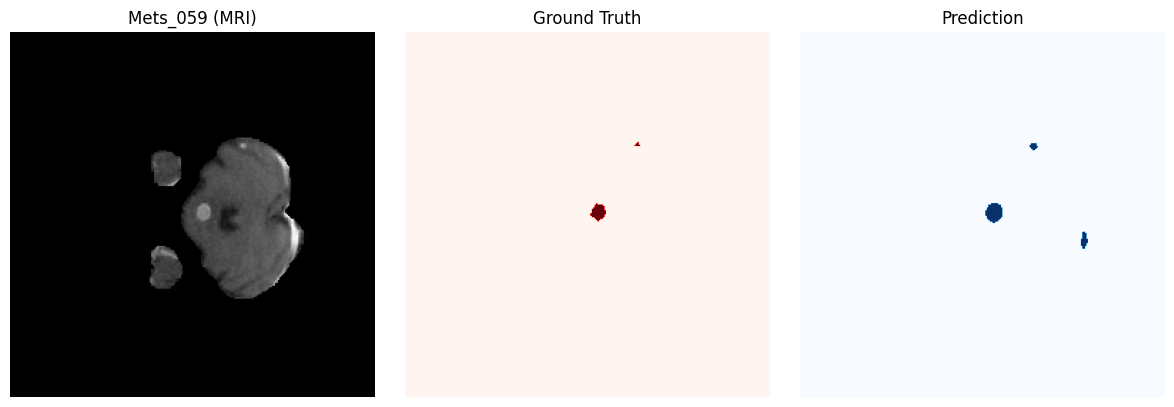

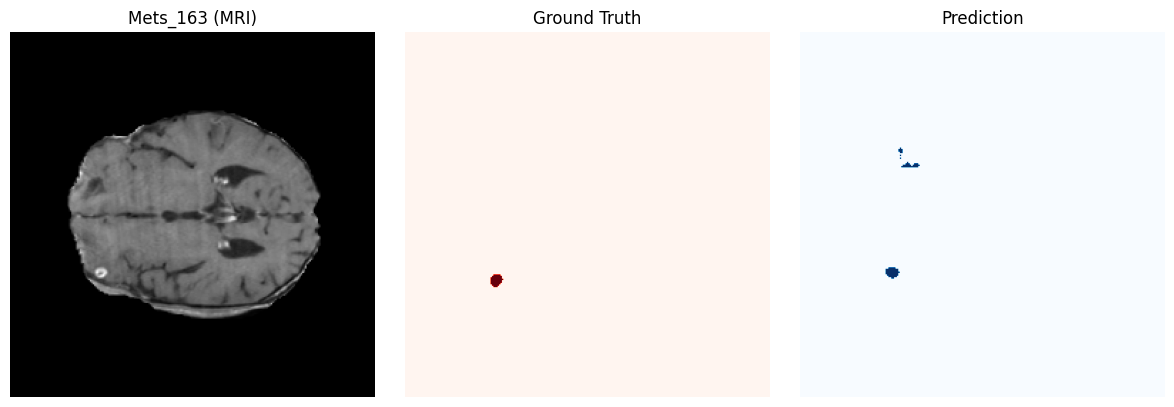

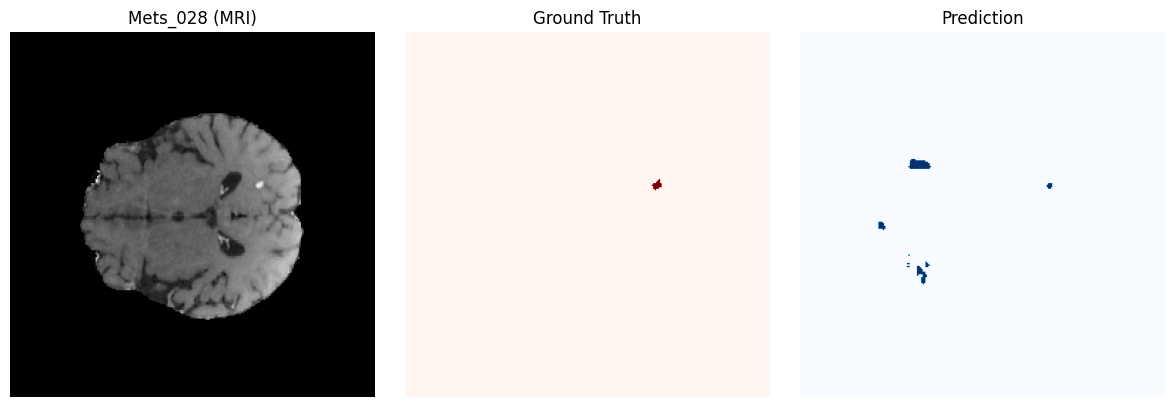

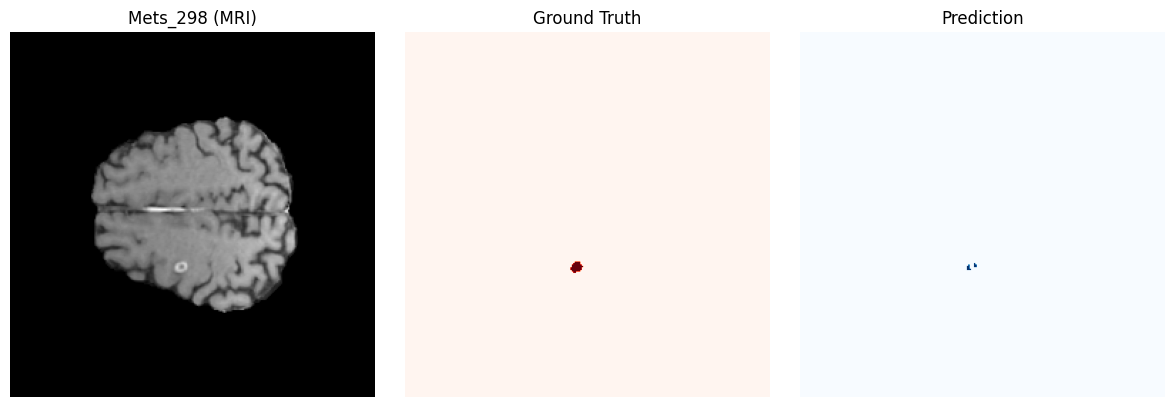

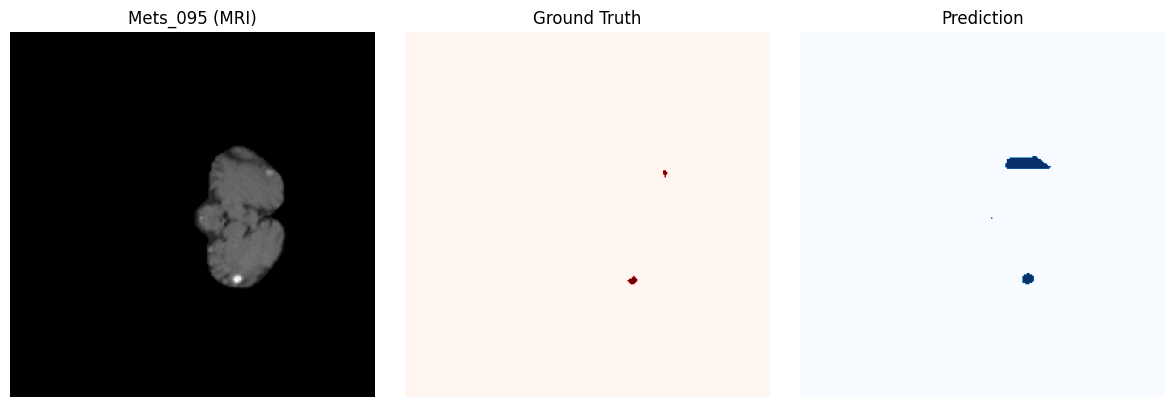

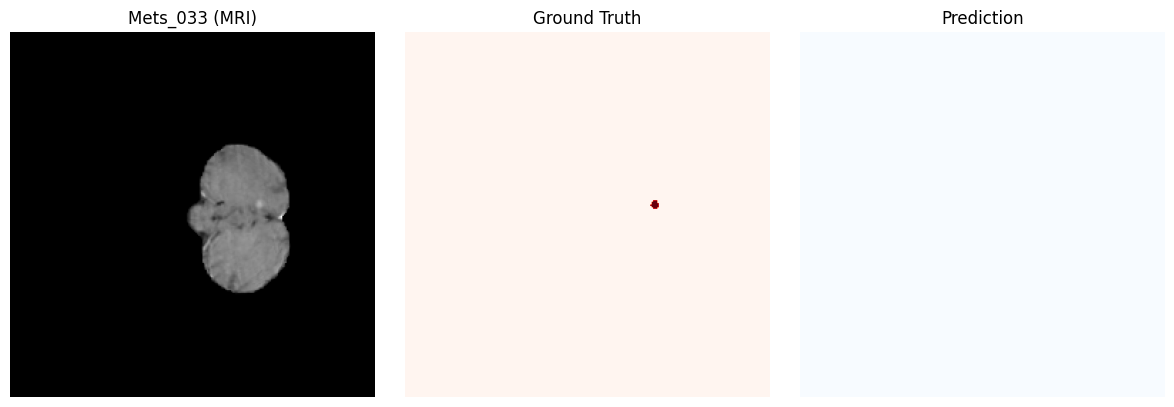

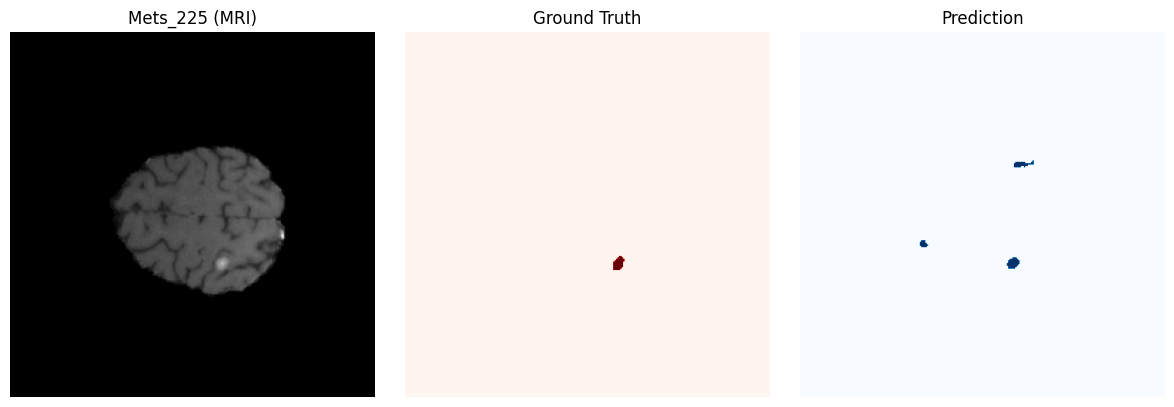

In [21]:
run_full_inference_visualization(test_dirs, model)